## Colab Prep

Execute the following code cells to whenever you open/restart the notebook in Google Colab.

In [ ]:
!pip install "polars[all]"

In [ ]:
!wget https://github.com/WSU-DataScience/dsci_325_module_7_more_data_management_in_python/raw/main/sample_data.zip

In [ ]:
!unzip ./sample_data.zip

In [ ]:
!pip install more_polars

# Stacking and Unstacking Data

In [2]:
import polars as pl

## Reshaping data

Two ways

* We can **stack** data into a *tall* format.
* We can **unstack** data into a *long* format.

## (totally real and not at all made-up) Example - Quarterly Auto Sales

**Note** the last four columns are

* same measurements
* same units

In [3]:
sales = pl.read_csv("./sample_data/auto_sales.csv")
sales

Salesperson,Compact,Sedan,SUV,Truck
str,i64,i64,i64,i64
"""Ann""",22,18,15,12
"""Bob""",19,12,17,20
"""Doug""",20,13,null,20
"""Yolanda""",19,8,32,15
"""Xerxes""",12,23,18,9


## Stacking measurements of the same type/units

<img src="https://github.com/WSU-DataScience/dsci_325_module_7_more_data_management_in_python/raw/main/img/stack_in_action.gif" width=600>

We can fix issues with informative column labels by stacking the data with `gather`

## A Stack by any other name ...

The act of stacking similar columns goes by various names.

* `polars` calls this `unpivot` [previously `melt`]
* JMP and Minitab call this *stack*
* Wickham/`tidyr`/`dfply` call this *gather*

I prefer **stack**, primarily because it makes it clear we are *melting*/*gathering* data vertically.

## Stacking data in `polars` with `unpivot`

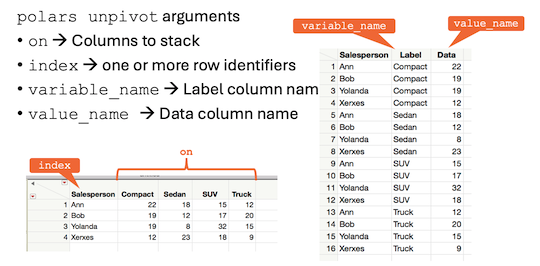

Syntax: `df.unpivot(on, index = ..., variable_name = ... , varaible_name = ..., value_name = ...)`

In [5]:
sales_cols = ['Compact', 'Sedan', 'SUV', 'Truck']
sales_stacked = (sales 
                 .unpivot(sales_cols, 
                          index='Salesperson', 
                          variable_name='CarType', 
                          value_name='QrtSales')
                )
sales_stacked

Salesperson,CarType,QrtSales
str,str,i64
"""Ann""","""Compact""",22
"""Bob""","""Compact""",19
"""Doug""","""Compact""",20
"""Yolanda""","""Compact""",19
"""Xerxes""","""Compact""",12
…,…,…
"""Ann""","""Truck""",12
"""Bob""","""Truck""",20
"""Doug""","""Truck""",20


## Unstacking Data with `pivot`

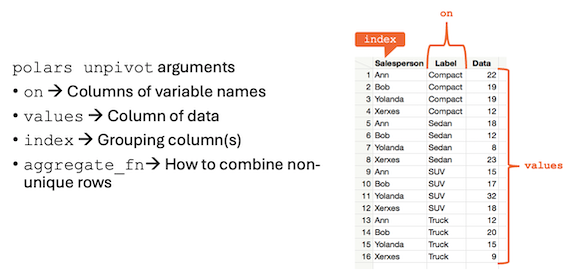

Syntax: `pivot(on, index = ..., values = ... , aggregate_fn = None)`

In [7]:
(sales_stacked
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'QrtSales')
)

Salesperson,Compact,Sedan,SUV,Truck
str,i64,i64,i64,i64
"""Ann""",22,18,15,12
"""Bob""",19,12,17,20
"""Doug""",20,13,null,20
"""Yolanda""",19,8,32,15
"""Xerxes""",12,23,18,9


## Safely STACK then UNSTACK


If we want to ensure we can unstack after stacking,

* Add an `ID`/`index` column of unique values
* Use this column as one of the index columns.
* Use `'first'` as the `aggregation_fn`.


In [8]:
(sales 
 .with_columns(ID = pl.sort(0, len(sales)))
 .unpivot(['ID', 'Salesperson'], sales_cols, "CarType","QrtSales")
 .pivot('QrtSales', ['ID','Salesperson'], 'CarType')
)

AttributeError: module 'polars' has no attribute 'sort'

## Aggregating with `pivot` for non-unique entries

Sometimes, we want to pivot on data with more than one row per `index`.  In this case, we must provide a summary function that is used to aggregate the non-unique values into a single entry.

### Examples - Using `pivot` to total three month of data

The file `combined_auto_sales_apr_to_jun.csv` contains three months of data, which means there are up to three rows per `Salesperson`.  

In [43]:
combined_auto_sales = pl.read_csv('./sample_data/combined_auto_sales_apr_to_jun.csv')

combined_auto_sales

Salesperson,CarType,QrtSales
str,str,i64
"""Ann""","""Compact""",22
"""Bob""","""Compact""",19
"""Yolanda""","""Compact""",19
"""Xerxes""","""Compact""",12
"""Ann""","""Compact""",18
…,…,…
"""Xerxes""","""Truck""",8
"""Ann""","""Truck""",12
"""Bob""","""Truck""",24


In this case, a `pivot` results in an exception letting us know there are non-unique entries.

In [50]:
(combined_auto_sales
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'QrtSales')
)

ComputeError: found multiple elements in the same group, please specify an aggregation function

We correct this issue by setting `aggregate_function='sum'` to compute the total overall duplicate rows

In [52]:
(combined_auto_sales
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'QrtSales',
       aggregate_function='sum'
       )
)

Salesperson,Compact,Sedan,SUV,Truck
str,i64,i64,i64,i64
"""Ann""",62,55,47,36
"""Bob""",59,41,31,67
"""Yolanda""",59,27,82,51
"""Xerxes""",35,75,54,26


While we could do this manually using `group_by` + `agg` + `unpivot`, this approach saves us two step!

In [57]:
# Brute force approach ==> requires two extra steps.

(combined_auto_sales
 .group_by(['Salesperson', 'CarType'])
 .agg(QrtSales = pl.col('QrtSales').sum())
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'QrtSales'
       )
)

Salesperson,Sedan,SUV,Truck,Compact
str,i64,i64,i64,i64
"""Yolanda""",27,82,51,59
"""Ann""",55,47,36,62
"""Xerxes""",75,54,26,35
"""Bob""",41,31,67,59


## Why Stack?

* Perform transformations on many columns.
* Fix problems with the Golden Rule

## Example - Switching Units on All Sales

Suppose your manager wants these numbers in *monthly* sales.  You could

1. Adjust each column with a separate formula
2. Stack --> Transform once --> Unstack

#### Method 1 - Brute-force Column Transformations

In [67]:
pl.Config.with_columns_kwargs = True

(sales
 .with_columns(Compact = pl.col('Compact')/3,
                SUV = pl.col('SUV')/3,
                Sedan = pl.col('Sedan')/3,
                Truck = pl.col('Truck')/3,
               )
)

Salesperson,Compact,Sedan,SUV,Truck
str,f64,f64,f64,f64
"""Ann""",7.333333,6.0,5.0,4.0
"""Bob""",6.333333,4.0,5.666667,6.666667
"""Doug""",6.666667,4.333333,null,6.666667
"""Yolanda""",6.333333,2.666667,10.666667,5.0
"""Xerxes""",4.0,7.666667,6.0,3.0


#### Method 2 - Stack-Transform-Unstack

In [65]:
(sales 
 .unpivot(sales_cols, 
         index='Salesperson', 
         variable_name='CarType', 
         value_name='QrtSales')
 .with_columns(MonSales = pl.col('QrtSales')/3)
 .drop('QrtSales')
 .pivot('CarType', 
        index = 'Salesperson', 
        values = 'MonSales'
       )
)

Salesperson,Compact,Sedan,SUV,Truck
str,f64,f64,f64,f64
"""Ann""",7.333333,6.0,5.0,4.0
"""Bob""",6.333333,4.0,5.666667,6.666667
"""Doug""",6.666667,4.333333,null,6.666667
"""Yolanda""",6.333333,2.666667,10.666667,5.0
"""Xerxes""",4.0,7.666667,6.0,3.0


#### Method 3 - Unpack a `dict` comprehension

We will cover this more indepth in a future DSCI 326 module

In [71]:
sales_cols = [col for col in sales.columns if col != 'Salesperson']

sales_cols

['Compact', 'Sedan', 'SUV', 'Truck']

In [74]:
(sales
 .with_columns(**{col:pl.col(col)/3 
                  for col in sales_cols}
               )
)

Salesperson,Compact,Sedan,SUV,Truck
str,f64,f64,f64,f64
"""Ann""",7.333333,6.0,5.0,4.0
"""Bob""",6.333333,4.0,5.666667,6.666667
"""Doug""",6.666667,4.333333,null,6.666667
"""Yolanda""",6.333333,2.666667,10.666667,5.0
"""Xerxes""",4.0,7.666667,6.0,3.0


## Comparing the two methods

**Method 1:**
* More straight forward
* Lots of repeated code
* Doesn't scale ... imagine 100+ columns

**Method 2:**
* More complicated
* Scales well $\longrightarrow$ same code regardless of number of columns
* Easier with more complicated transformations

**Method 3:**
* More abstract
* By far the most sussinct

## <font color="red"> Exercise 7.2.1 </font>
    
**Task:** Load the `Artwork.csv` data and use the Stack-Transform-Unstack trick to convert all measurements in cm to mm.

**Hints.**
1. You will need to fix the `dtypes` for some of the measurement columns by passing the `artwork_dtypes` to `pl.read_csv`.
2. You will want to add an `ID` column to make the stack and unstack safe.
3. You can use `cols.from_` and `cols.to` to get the list of columns needed in `melt`.
4. `pivot` can't group by float columns, so you need to stack all measurements.
5. To process only the `cm` columns, use a `pl.when(cond).then(expr).otherwise(expr)` expression.
6. You should also replace the `cm` with `mm` in the label column (using the same trick in the last hint) before unstacking.

In [25]:
artwork_dtypes = {'Title': pl.datatypes.Utf8,
                  'Artist': pl.datatypes.Utf8,
                  'ConstituentID': pl.datatypes.Utf8,
                  'ArtistBio': pl.datatypes.Utf8,
                  'Nationality': pl.datatypes.Utf8,
                  'BeginDate': pl.datatypes.Utf8,
                  'EndDate': pl.datatypes.Utf8,
                  'Gender': pl.datatypes.Utf8,
                  'Date': pl.datatypes.Utf8,
                  'Medium': pl.datatypes.Utf8,
                  'Dimensions': pl.datatypes.Utf8,
                  'CreditLine': pl.datatypes.Utf8,
                  'AccessionNumber': pl.datatypes.Utf8,
                  'Classification': pl.datatypes.Utf8,
                  'Department': pl.datatypes.Utf8,
                  'DateAcquired': pl.datatypes.Utf8,
                  'Cataloged': pl.datatypes.Utf8,
                  'ObjectID': pl.datatypes.Int64,
                  'URL': pl.datatypes.Utf8,
                  'ThumbnailURL': pl.datatypes.Utf8,
                  'Circumference (cm)': pl.datatypes.Float64,
                  'Depth (cm)': pl.datatypes.Float64,
                  'Diameter (cm)': pl.datatypes.Float64,
                  'Height (cm)': pl.datatypes.Float64,
                  'Length (cm)': pl.datatypes.Float64,
                  'Weight (kg)': pl.datatypes.Float64,
                  'Width (cm)': pl.datatypes.Float64,
                  'Seat Height (cm)': pl.datatypes.Float64,
                  'Duration (sec.)': pl.datatypes.Float64}

In [31]:
# Your code here